# Introduction 

This builds a basic VAMPnets model without the deeptime module. The resulting output will still be put in a deptime VAMP model to compare to the deeptime version. 

In [40]:
from copy import deepcopy
from pathlib import Path
from itertools import combinations
import pickle as pk


import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from addict import Dict as Adict
import mdshare
import seaborn as sns
import matplotlib.pyplot as plt

from deeptime.util.types import to_dataset
from deeptime.decomposition import VAMP
from deeptime.decomposition.deep import vampnet_loss

%reload_ext autoreload
%autoreload 2
from celerity.models import VAMPnetEstimator, VAMPNetModel


In [41]:
dihedral_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-backbone-dihedrals.npz", working_directory='data'
)

### Load data

In [42]:
with np.load(Path('data/alanine-dipeptide-3x250ns-heavy-atom-positions.npz').open('rb')) as fh:
    data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]

with np.load(dihedral_file) as fh:
    dihedral = [fh[f"arr_{i}"] for i in range(3)]

### Configuration

In [43]:
lag_time = 1
validation_split = 0.3
batch_size = 1000

# vampnet estimator config
nn_config = Adict(
        lag_time = lag_time, 
        network_dimensions = [30, 100, 100, 6], 
        lr = 5e-3, 
        n_epochs = 5, 
        optimizer=torch.optim.Adam, 
      #   scheduler=torch.optim.lr_scheduler.ExponentialLR, 
      #   scheduler_kwargs = Adict(gamma = 0.5), 
        
        score = Adict(
              method='VAMP2', 
              mode='regularize', 
              epsilon=1e-6
        ), 
        loss = vampnet_loss, 
        device="cuda"
    ) 

In [44]:
dataset = to_dataset(data=data, lagtime=lag_time)
n_val = int(len(dataset)*validation_split)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False) 
loader_traj = DataLoader(data[0], batch_size=len(data[0]), shuffle=False)
loader_trajs = [DataLoader(x, batch_size=len(x), shuffle=False) for x in data]

### Fit and transform

In [45]:
est = VAMPnetEstimator(nn_config)

est.fit(loader_train, loader_val, record_interval=10)
mod = VAMPNetModel({'estimator': est, 'device': 'cuda'})

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/525 [00:00<?, ?it/s]

Batch:   0%|          | 0/525 [00:00<?, ?it/s]

Batch:   0%|          | 0/525 [00:00<?, ?it/s]

Batch:   0%|          | 0/525 [00:00<?, ?it/s]

Batch:   0%|          | 0/525 [00:00<?, ?it/s]

In [46]:
val_steps = np.sort(list(est.dict_scores['validate']['VAMP2'].keys()))
train_steps =np.sort(list(est.dict_scores['train']['VAMP2'].keys())) 
train_vals = np.array([est.dict_scores['train']['VAMP2'][step] for step in train_steps])
val_vals = np.array([est.dict_scores['validate']['VAMP2'][step] for step in val_steps])
val_steps = val_steps*batch_size
train_steps = train_steps*batch_size

pk.dump(file=open('adam_training_scores.pkl', 'wb'), obj=(val_steps, val_vals))

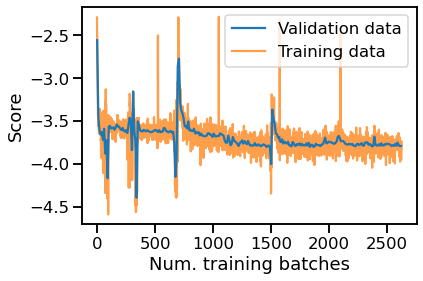

In [47]:
val_steps = np.sort(list(est.dict_scores['validate']['VAMP2'].keys()))
train_steps =np.sort(list(est.dict_scores['train']['VAMP2'].keys())) 
train_vals = np.array([est.dict_scores['train']['VAMP2'][step] for step in train_steps])
val_vals = np.array([est.dict_scores['validate']['VAMP2'][step] for step in val_steps])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots()
    ax.plot(val_steps, -1*val_vals, label='Validation data', zorder=1)

    ax.plot(train_steps, -1*train_vals, label='Training data', alpha=0.75, zorder=0)
    ax.set_ylabel('Score')
    ax.set_xlabel('Num. training batches')
    ax.legend()
    plt.savefig('figures/training_score.png', dpi=450, bbox_inches='tight')

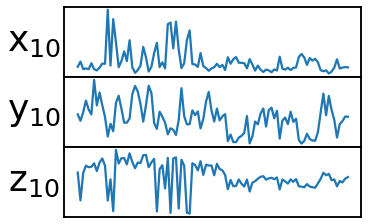

In [48]:
with sns.plotting_context('talk', font_scale=2): 
    fig, ax = plt.subplots(3, sharey=False)
    offset = 27
    for i, j in enumerate(range(offset, offset+3)):
        ax[i].plot(data[0][:100, j])
 
        ax[i].tick_params(bottom=False, labelbottom=False)
        ax[i].tick_params(left=False, labelleft=False)
        ax[i].set_ylabel(f"{['x', 'y', 'z'][j%3]}$_{{{j//3+1}}}$", 
                        rotation=0, labelpad=30, va='center')

    plt.tight_layout(h_pad=0)
    plt.savefig(f'figures/inputs_{offset}-{offset+3}.png', dpi=450)

### State assigments and timescales

In [49]:
state_probabilities = mod.transform(loader_traj)
assignments = state_probabilities[0].argmax(1)
cols = sns.color_palette('colorblind', nn_config.network_dimensions[-1])
dihedral_deg = np.rad2deg(dihedral[0])
dihedral_deg = dihedral_deg[::10, :]
dihedral_rad = dihedral[0][::10, :]
assignments = assignments[::10]
state_cols = [cols[i] for i in assignments]


Transform:   0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
pk.dump(file=open('adam_ave_predictions.pkl', 'wb'), obj=state_probabilities)

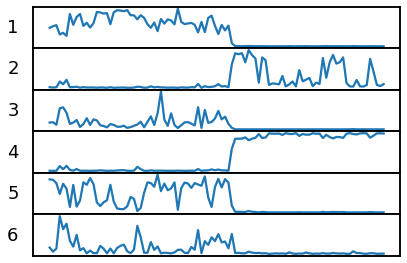

In [51]:
with sns.plotting_context('talk', font_scale=1): 
    fig, ax = plt.subplots(6, sharey=False)
    offset = 0
    for i, j in enumerate(range(6)):
        ax[i].plot(state_probabilities[0][:100, j])
 
        ax[i].tick_params(bottom=False, labelbottom=False)
        ax[i].tick_params(left=False, labelleft=False)
        ax[i].set_ylabel(f"{j+1}", rotation=0, labelpad=20, va='center')

    plt.tight_layout(h_pad=0)
    plt.savefig(f'figures/outputs.png', dpi=450)

In [52]:
dihedral_deg.shape

(25000, 2)

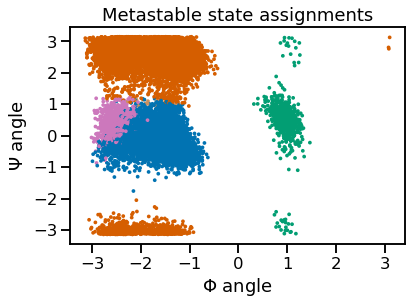

In [53]:


with sns.plotting_context('talk'):
    n_params = np.sum([len(x) for x in list(est.parameters())])
    optimizer = est.options.optimizer.__name__
    n_epochs = est.options.n_epochs

    fig, ax = plt.subplots(1)
    cols = sns.color_palette('colorblind', nn_config.network_dimensions[-1])

    ax.scatter(*dihedral_rad.T, c=state_cols, s=5, alpha=1)
    ax.set_title('Metastable state assignments')
    ax.set_xlabel('$\Phi$ angle')
    ax.set_ylabel('$\Psi$ angle')
    plt.savefig(f'figures/ala2_states_{optimizer}_{n_epochs}-epochs_{n_params}-params.pdf', bbox_inches='tight')

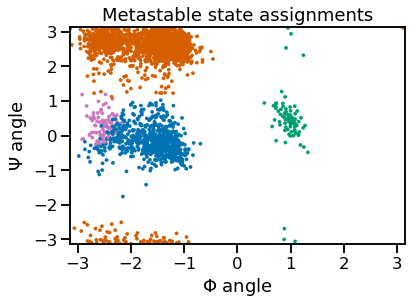

In [54]:
with sns.plotting_context('talk'):
    states = [2, 3, 4, 0]
    n_params = np.sum([len(x) for x in list(est.parameters())])
    optimizer = est.options.optimizer.__name__
    n_epochs = est.options.n_epochs

    fig, ax = plt.subplots(1)
    cols = sns.color_palette('colorblind', nn_config.network_dimensions[-1])

    ix = np.where(np.isin(assignments, states))[0][::10]

    ax.scatter(*dihedral_rad[ix, :].T, c=np.array(state_cols)[ix], s=5, alpha=1)


    ax.set_title('Metastable state assignments')
    ax.set_xlabel('$\Phi$ angle')
    ax.set_ylabel('$\Psi$ angle')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    plt.savefig(f'figures/ala2_states_{optimizer}_{n_epochs}-epochs_{n_params}-params-n_states-{len(states)}.pdf', bbox_inches='tight')

In [55]:
state_probabilities = [mod.transform(loader)[0] for loader in loader_trajs]

vamp_estimator = VAMP(lagtime=lag_time)
vamp_estimator.fit_from_timeseries(state_probabilities)
vamp_model = vamp_estimator.fetch_model()
with np.printoptions(precision=1, suppress=True):
    print(vamp_model.timescales(5))

Transform:   0%|          | 0/1 [00:00<?, ?it/s]

Transform:   0%|          | 0/1 [00:00<?, ?it/s]

Transform:   0%|          | 0/1 [00:00<?, ?it/s]

[1117.1   56.9    2.2    1.5    1. ]


In [56]:
n_timescales = 3 

lags = np.arange(1, 101, 1)
timescales = np.empty((n_timescales, len(lags)))
for i, lag_time in enumerate(lags):
    vamp_estimator = VAMP(lagtime=lag_time)
    vamp_estimator.fit_from_timeseries(state_probabilities)
    vamp_model = vamp_estimator.fetch_model()
    timescales[:, i] = vamp_model.timescales(n_timescales)

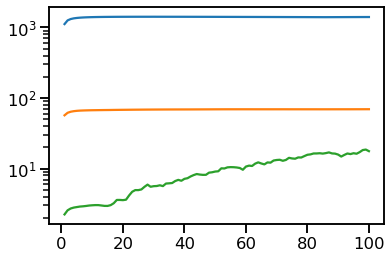

In [57]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1)
    ax.plot(lags, timescales.T)
    ax.set_yscale('log')
    

In [58]:
pk.dump(file=open('adam_timescales.pkl', 'wb'), obj=(lags, timescales))